In [2]:
import pandas as pd
import numpy as np
from utils.conn_data import load_pickle
import os
from os.path import join
import glob
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

In [3]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")

# fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam", "dynotears"]
fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam"]

In [4]:
outputs_path

'/Users/danieloliveira/Documents/Daniel/codes/cml-fin/src/data/outputs'

In [13]:
class backtester:
    def __init__(self, dfPred):
        self.yPred = dfPred["prediction"]
        self.yTrue = dfPred["true"]
        
    def simpleStrategy(self):
        self.stratName = "simple"
        self.pnl = np.sign(self.yPred) * self.yTrue
        #self.pnl = self.pnl.reshape(-1)
        return self.pnl

def calculateRollingSharpeRatio(dfPnl, window = 3, annulaize = 12, rf = 0):
    rolling_sr = (dfPnl.rolling(window=window).mean() - rf) / dfPnl.rolling(window=window).std() * np.sqrt(annulaize)
    return rolling_sr

def calculateSharpeRatio(dfPnl, annulaize = 12, rf = 0):
    sr = (dfPnl.mean() - rf) / dfPnl.std() * np.sqrt(annulaize)
    return sr

def calculateAnnualizedReturn(dfPnl, annulaize = 12):
    cr = dfPnl.mean() * annulaize * 100
    return cr

In [32]:
etf = "XLE"
for i, fs in enumerate(fs_methods):
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", f"{etf}*.pickle"))
    dfPred = load_pickle(results_files[0])["predictions"]
    dfPred = np.log(1 + dfPred / 100)
    
    bt = backtester(dfPred)
    bt.simpleStrategy()
    
    if i == 0:
        dfPnl = dfPred[["true"]].copy()
        dfPnl.columns = [etf]
    dfPnl[fs] = bt.pnl

    

In [34]:
calculateSharpeRatio(dfPnl)

XLE                     0.330443
lasso                   0.471921
multivariate-granger    0.568057
pairwise-granger        0.475813
var-lingam              0.455939
dtype: float64

In [35]:
calculateAnnualizedReturn(dfPnl)

XLE                     0.089201
lasso                   0.125620
multivariate-granger    0.147692
pairwise-granger        0.127823
var-lingam              0.062203
dtype: float64

<AxesSubplot:>

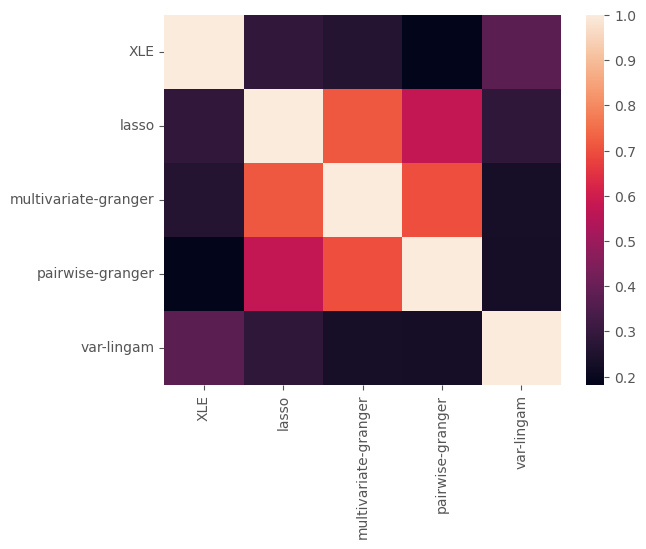

In [36]:
sns.heatmap(dfPnl.corr())

Text(0, 0.5, 'Cumulative returns (%)')

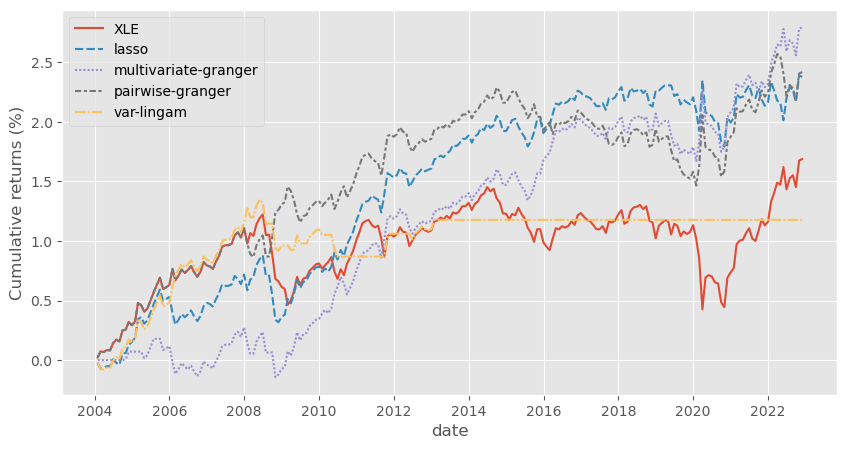

In [37]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
sns.lineplot(data = dfPnl.cumsum() * 100, ax = ax)
ax.set_ylabel("Cumulative returns (%)")

Text(0, 0.5, 'Sharpe difference')

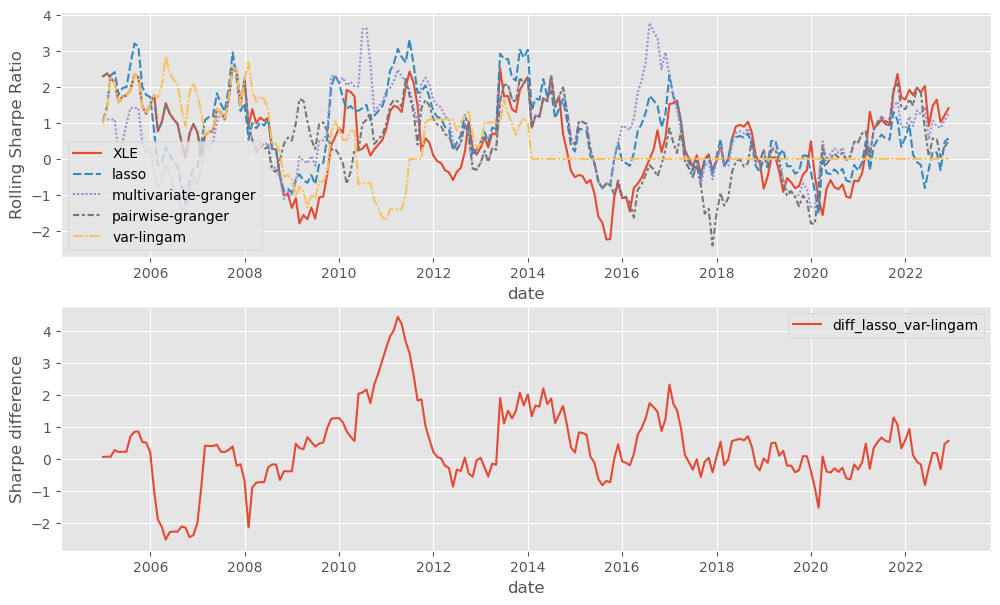

In [38]:
rolling_sharpe_df = dfPnl.apply(lambda x: calculateRollingSharpeRatio(x, window = 12), axis = 0)
rolling_sharpe_diff_df = pd.DataFrame(rolling_sharpe_df["lasso"] - rolling_sharpe_df["var-lingam"], columns=["diff_lasso_var-lingam"])

fig, ax = plt.subplots(2, 1, figsize = (12, 7))
sns.lineplot(data = rolling_sharpe_df, ax = ax[0])
ax[0].set_ylabel("Rolling Sharpe Ratio")
sns.lineplot(data = rolling_sharpe_diff_df, ax = ax[1])
ax[1].set_ylabel("Sharpe difference")

In [35]:
# fig.savefig("PnLPlot.png", bbox_inches = "tight")